# Testing Reliability of Prompting
- Comparing logits with LLM answer
- Given a specific answer how big is the corresponding token probability?


In [1]:
# packages and helpers
import random
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import pandas as pd
import gc
import matplotlib.pyplot as plt
import numpy as np


def randomized_choice_numbers():
    possible_pairs = [[1, 2, 3, 4, 5], [5, 4, 3, 2, 1], ["A", "B", "C", "D", "E"], ["E", "D", "C", "B", "A"]]
    var_1, var_2, var_3, var_4, var_5 = random.choice(possible_pairs)
    return var_1, var_2, var_3, var_4, var_5

def randomized_connectors():
    possible_connectors = [":", "=", "means"]
    connector = random.choice(possible_connectors)
    return connector

def randomized_prompt():
    var1, var2, var3, var4, var5 = randomized_choice_numbers()
    remember_vars = [var1, var2, var3, var4, var5]
    connector = randomized_connectors()
    prompt = f"""
How do you see yourself: are you generally fully prepared to take risks or do you try to avoid taking risks?
Please reply with one of the following options:
{var1} {connector} ‘not at all willing to take risks’, 
{var2} {connector} ‘rarely willing to take risks’, 
{var3} {connector} ‘sometimes willing to take risks’, 
{var4} {connector} ‘willing to take risks’, 
{var5} {connector} ‘very willing to take risks’.
Please answer with the option between {var1} and {var5} that describes you best.
Answer:
"""
    return prompt, remember_vars, connector

def normalize_scale(row):
    start, mid, mid2, mid3, end = row["prompt_numbers"]
    tokens = row["Token"].copy()
    probs  = row["Probability"].copy()

    if [start, mid, mid2, mid3, end] == [1, 2, 3, 4, 5]:
        # nothing to change, except deleting value for 9
        #tokens.pop()
        #probs.pop()
        return tokens, probs
    
    elif [start, mid, mid2, mid3, end] == [5, 4, 3, 2, 1]:
        #tokens.pop()
        #probs.pop()
        probs.reverse()
        return tokens, probs

    elif [start, mid, mid2, mid3, end] == ["A", "B", "C", "D", "E"]:
        #tokens.pop()
        # shift down by 1
        #probs.pop(0)        
        return tokens, probs

    elif [start, mid, mid2, mid3, end] == ["E", "D", "C", "B", "A"]:
        # reverse order + shift
        #tokens.pop()
        #probs.pop(0)
        probs.reverse()
        return tokens, probs

    else:
        raise ValueError(f"Unexpected scale {start} → {end}")


In [2]:
# Load model and tokenizer
model_names = ["HuggingFaceTB/SmolLM2-1.7B-Instruct",  "unsloth/Qwen3-1.7B", "unsloth/Qwen3-4B"] # "bigscience/bloomz-3b", "tiiuae/falcon-7b-instruct"]
short_model_names = ["SmolLM2-1.7B-I", "Qwen3-1.7B-I","Qwen3-4B-I" ,"bloomz-3b1", "bloomz-3b", "falcon-7b-i"]


In [3]:
save_data_in_table_list = []
j=0
for model_name in model_names:
	short_model_name = short_model_names[j]
	j+=1
	tokenizer = AutoTokenizer.from_pretrained(model_name)
	model = AutoModelForCausalLM.from_pretrained(model_name)

	for i in range(30):
		# generate prompt with random number combi
		prompt, remember_vars, connector  = randomized_prompt()

		# Model specific chat template for prompting
		messages = [
			{"role": "user", "content": prompt},
		]

		# input settings
		inputs = tokenizer.apply_chat_template(
			messages,
			add_generation_prompt=True,
			tokenize=True,
			return_dict=True,
			return_tensors="pt",
			skip_special_tokens=True,
			enable_thinking=False
		).to(model.device)

		# generate output text and print
		generated_outputs = model.generate(**inputs, max_new_tokens=40)
		generated_text = tokenizer.decode(
			generated_outputs[0][inputs["input_ids"].shape[-1]:],
				skip_special_tokens=True)

		#print("Generated text:", generated_text)

		# generate output logits (from inner last layer of model)
		with torch.no_grad():
			logit_outputs = model(**inputs)
			logits = logit_outputs.logits

		# Take the logits for the *last* position in the prompt
		next_token_logits = logits[0, -1, :]

		# Convert to probabilities
		probs = torch.softmax(next_token_logits, dim=-1)

		# Extract most likely token (= max logit value) and its prob (i.e. softmax function = exp of logits and divided by sum of all expnential logits so that probs sum up to)
		predicted_id = torch.argmax(probs).item()
		predicted_token = tokenizer.decode(predicted_id)
		predicted_prob = probs[predicted_id].item()

		# Extract the *actual generated* token and its prob at first response position!
		# Take only the first token
		generated_tokens = generated_outputs[0][inputs["input_ids"].shape[-1]:]
		first_generated_id = generated_tokens[0].item()
		actual_token = tokenizer.decode([first_generated_id], skip_special_tokens=True)
		actual_prob = probs[first_generated_id].item()

		# Add probabilities for 1-5
		# Get token IDs for numbers 1–5
		if remember_vars == [1, 2, 3, 4, 5] or remember_vars == [5, 4, 3, 2, 1]:
			token_ids = [tokenizer.encode(str(i), add_special_tokens=False)[0] for i in range(1, 6)]
		elif remember_vars == ["A", "B", "C", "D", "E"] or remember_vars == ["E", "D", "C", "B", "A"]:
			token_ids = [tokenizer.encode(str(i), add_special_tokens=False)[0] for i in ["A", "B", "C", "D", "E"]]
		# Extract their probabilities
		selected_probs = probs[token_ids]
		# Decode tokens for display
		tokens = [tokenizer.decode([tid]) for tid in token_ids]
		probs_list = selected_probs.tolist()

		save_data_in_table_list.append(
			{
				"model": short_model_name,
				"prompt_numbers": remember_vars,
				"connector": connector,
				"predicted_token": predicted_token,
				"predicted_prob": predicted_prob,
				"actual_token": actual_token,
				"actual_prob": actual_prob,
				"Token": tokens,
				"Probability": probs_list
			}
		)
	# After finishing work with the model
	print(f"Model {short_model_name} done!")
	del model
	del tokenizer

	# Run garbage collector
	gc.collect()

df = pd.DataFrame(save_data_in_table_list)


Model SmolLM2-1.7B-I done!
Model Qwen3-1.7B-I done!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model Qwen3-4B-I done!


In [4]:
df

,model,prompt_numbers,connector,predicted_token,predicted_prob,actual_token,actual_prob,Token,Probability
0,SmolLM2-1.7B-I,"[A, B, C, D, E]",means,B,0.398621,B,0.398621,"[A, B, C, D, E]","[0.09525986015796661, 0.3986208438873291, 0.21..."
1,SmolLM2-1.7B-I,"[5, 4, 3, 2, 1]",means,1,0.289154,1,0.289154,"[1, 2, 3, 4, 5]","[0.2891535758972168, 0.25050660967826843, 0.13..."
2,SmolLM2-1.7B-I,"[5, 4, 3, 2, 1]",=,1,0.324262,1,0.324262,"[1, 2, 3, 4, 5]","[0.32426172494888306, 0.24699321389198303, 0.1..."
3,SmolLM2-1.7B-I,"[5, 4, 3, 2, 1]",:,1,0.412259,1,0.412259,"[1, 2, 3, 4, 5]","[0.4122586250305176, 0.2601129114627838, 0.127..."
4,SmolLM2-1.7B-I,"[1, 2, 3, 4, 5]",means,4,0.331133,4,0.331133,"[1, 2, 3, 4, 5]","[0.10213032364845276, 0.03898458555340767, 0.1..."
...,...,...,...,...,...,...,...,...,...
85,Qwen3-4B-I,"[E, D, C, B, A]",means,B,0.999993,B,0.999993,"[A, B, C, D, E]","[4.277067091607023e-06, 0.9999929666519165, 1...."
86,Qwen3-4B-I,"[5, 4, 3, 2, 1]",means,2,0.981762,2,0.981762,"[1, 2, 3, 4, 5]","[0.0028808473143726587, 0.9817620515823364, 0...."
87,Qwen3-4B-I,"[A, B, C, D, E]",:,D,0.999987,D,0.999987,"[A, B, C, D, E]","[1.1171017236244474e-11, 1.2010210603818905e-0..."
88,Qwen3-4B-I,"[A, B, C, D, E]",=,D,0.999004,D,0.999004,"[A, B, C, D, E]","[4.6117158702951855e-11, 1.2302918683815278e-0..."


In [5]:
#df.to_csv("tryPromptingData.csv", index=False)

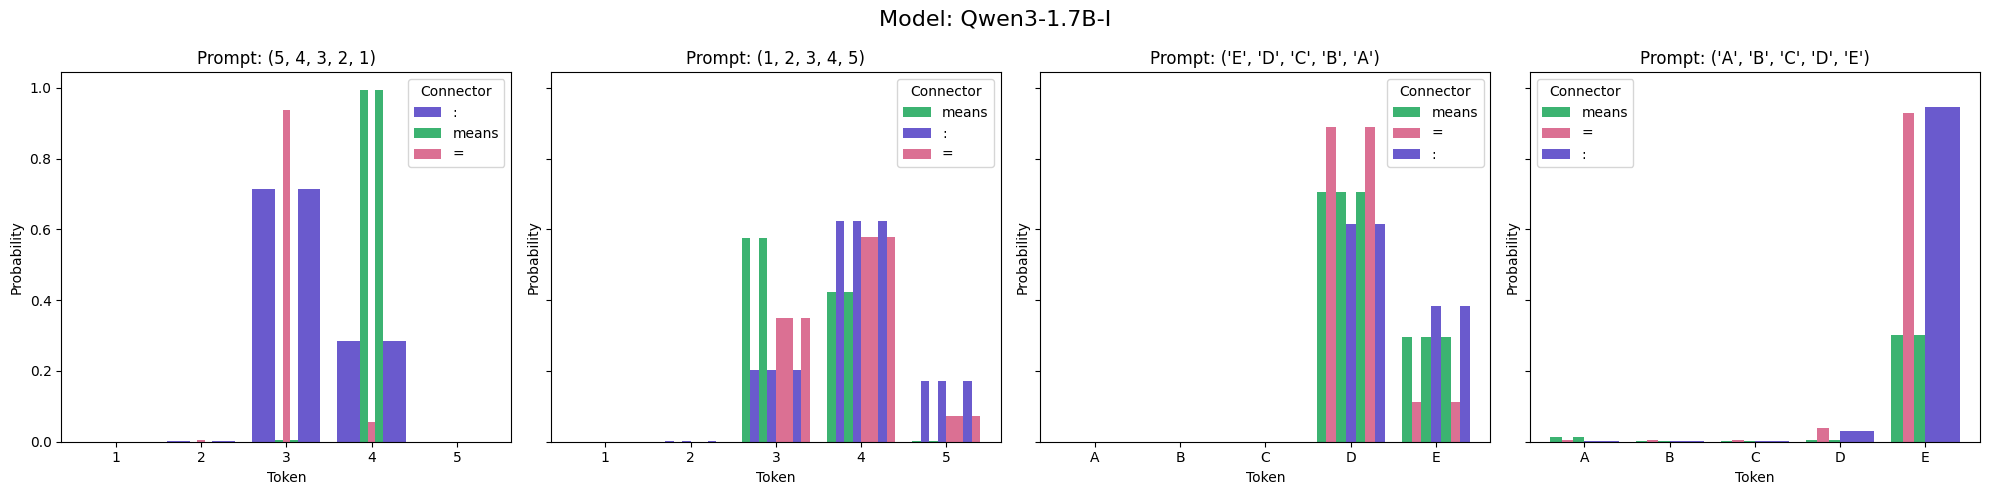

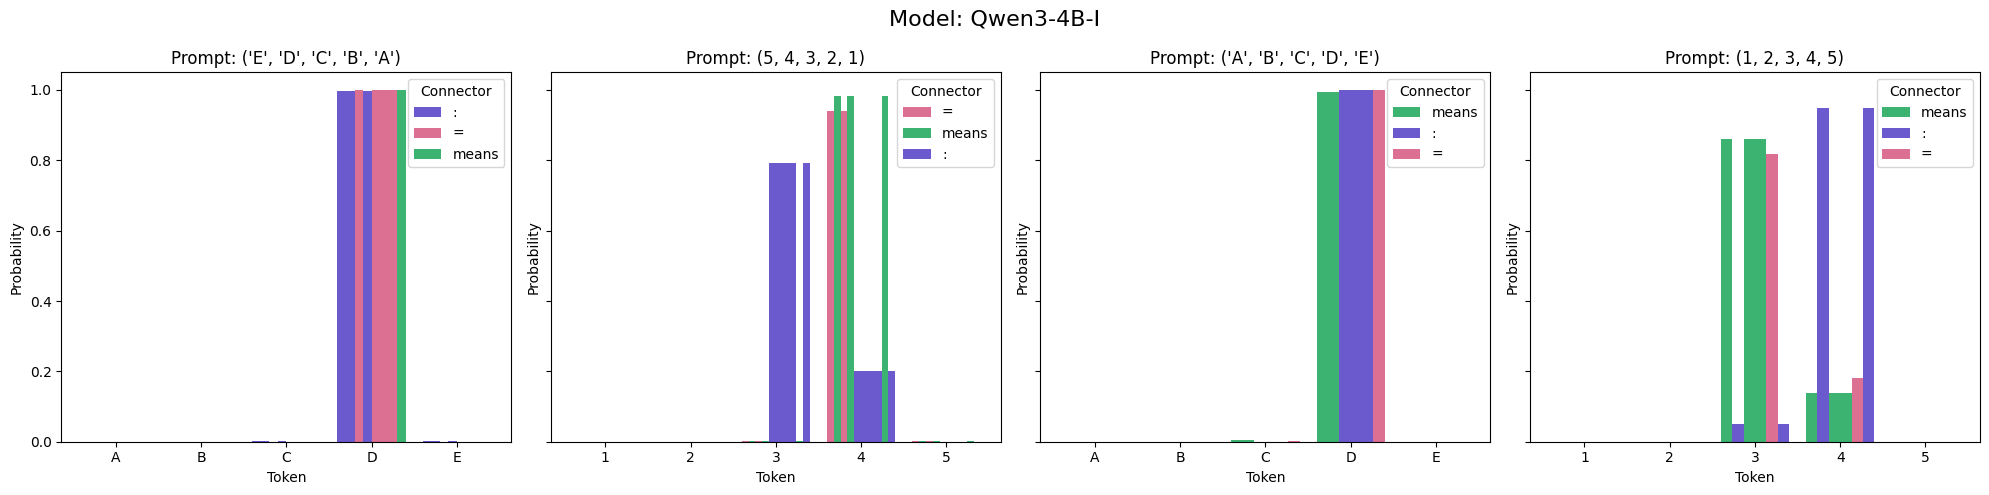

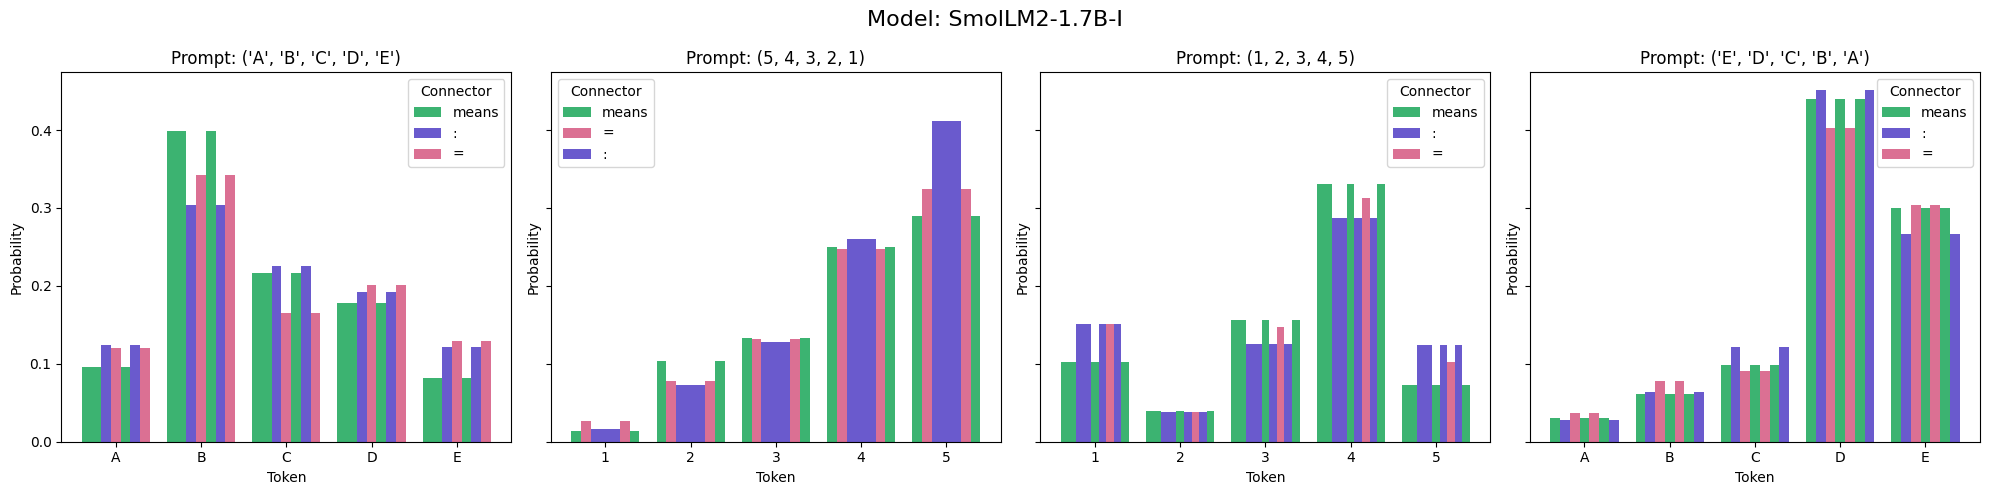

In [6]:
# zurück auf einen Nenner bringen, für verbesserte Vergleichbarkeit. 

# Apply function to normalize scales to dataframe
df[["Token_normalized", "Prob_normalized"]] = df.apply(
    lambda row: pd.Series(normalize_scale(row)), axis=1
)


# Choose a color for each connector type
connector_colors = {
    ":": "slateblue",
    "=": "palevioletred",
    "means": "mediumseagreen"
}

df["prompt_tuple"] = df["prompt_numbers"].apply(lambda x: tuple(x))

# Loop over each model
for model, model_df in df.groupby("model"):

    # Get unique prompt_numbers within this model
    prompts = model_df["prompt_tuple"].unique()
    n_prompts = len(prompts)

    # Create one column per prompt_numbers
    fig, axes = plt.subplots(1, n_prompts, figsize=(5*n_prompts, 5), sharey=True)

    # If only 1 prompt, axes is not a list
    if n_prompts == 1:
        axes = [axes]

    for ax, prompt in zip(axes, prompts):
        subset = model_df[model_df["prompt_tuple"] == prompt]

        # Assume all rows have the same tokens order
        tokens = subset.iloc[0]["Token_normalized"]
        x = np.arange(len(tokens))
        width = 0.8 / len(subset)   # distribute bars within each token group

        # Plot each run (row) as a differently colored bar
        for i, (_, row) in enumerate(subset.iterrows()):
            probs = row["Prob_normalized"]
            connector = row["connector"]
            color = connector_colors.get(connector, "gray")  # default to gray if missing
            ax.bar(x + i*width, probs, width, label=f"{connector}" if connector not in ax.get_legend_handles_labels()[1] else "",
                   color=color)

        ax.set_title(f"Prompt: {prompt}")
        ax.set_xticks(x + width*(len(subset)-1)/2)
        ax.set_xticklabels(tokens)
        ax.set_xlabel("Token")
        ax.set_ylabel("Probability")
        ax.legend(title="Connector")

    fig.suptitle(f"Model: {model}", fontsize=16)
    plt.tight_layout()
    plt.show()


# Systematic Approach

In [7]:
from itertools import product

# all permutations of prompt numbers
possible_pairs = [
    [1, 2, 3, 4, 5],
    [5, 4, 3, 2, 1],
    ["A", "B", "C", "D", "E"],
    ["E", "D", "C", "B", "A"],
]
possible_connectors = [":", "=", "means"]

# Build a list of (model, numbers, connector) combinations
all_combinations = list(product(model_names, possible_pairs, possible_connectors))


In [8]:
def build_prompt(numbers, connector):
    var1, var2, var3, var4, var5 = numbers
    prompt = f"""
How do you see yourself: are you generally fully prepared to take risks
or do you try to avoid taking risks?
Please reply with one of the following options:
{var1} {connector} ‘not at all willing to take risks’,
{var2} {connector} ‘rarely willing to take risks’,
{var3} {connector} ‘sometimes willing to take risks’,
{var4} {connector} ‘willing to take risks’,
{var5} {connector} ‘very willing to take risks’.
Please answer with the option between {var1} and {var5} that describes you best.
Answer:
""".strip()
    return prompt


In [9]:
save_data_in_table_list = []

for model_name, numbers, connector in all_combinations:
    short_model_name = short_model_names[model_names.index(model_name)]

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    prompt = build_prompt(numbers, connector)

    messages = [{"role": "user", "content": prompt}]
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
        skip_special_tokens=True,
        enable_thinking=False
    ).to(model.device)

    generated_outputs = model.generate(**inputs, max_new_tokens=40)
    generated_text = tokenizer.decode(
        generated_outputs[0][inputs["input_ids"].shape[-1]:],
        skip_special_tokens=True
    )

    with torch.no_grad():
        logits = model(**inputs).logits

    next_token_logits = logits[0, -1, :]
    probs = torch.softmax(next_token_logits, dim=-1)

    predicted_id = torch.argmax(probs).item()
    predicted_token = tokenizer.decode(predicted_id)
    predicted_prob = probs[predicted_id].item()

    generated_tokens = generated_outputs[0][inputs["input_ids"].shape[-1]:]
    first_generated_id = generated_tokens[0].item()
    actual_token = tokenizer.decode([first_generated_id], skip_special_tokens=True)
    actual_prob = probs[first_generated_id].item()

    # Determine candidate tokens (numbers or letters)
    if numbers in ([1,2,3,4,5], [5,4,3,2,1]):
        token_ids = [tokenizer.encode(str(i), add_special_tokens=False)[0] for i in [1,2,3,4,5]]
    else:
        token_ids = [tokenizer.encode(c, add_special_tokens=False)[0] for c in ["A","B","C","D","E"]]

    selected_probs = probs[token_ids]
    tokens = [tokenizer.decode([tid]) for tid in token_ids]
    probs_list = selected_probs.tolist()

    save_data_in_table_list.append({
        "model": short_model_name,
        "prompt_numbers": numbers,
        "connector": connector,
        "predicted_token": predicted_token,
        "predicted_prob": predicted_prob,
        "actual_token": actual_token,
        "actual_prob": actual_prob,
        "Token": tokens,
        "Probability": probs_list
    })

    print(f"Finished {short_model_name} | {numbers} | {connector}")

    del model, tokenizer
    gc.collect()

df = pd.DataFrame(save_data_in_table_list)


Finished SmolLM2-1.7B-I | [1, 2, 3, 4, 5] | :
Finished SmolLM2-1.7B-I | [1, 2, 3, 4, 5] | =
Finished SmolLM2-1.7B-I | [1, 2, 3, 4, 5] | means
Finished SmolLM2-1.7B-I | [5, 4, 3, 2, 1] | :
Finished SmolLM2-1.7B-I | [5, 4, 3, 2, 1] | =
Finished SmolLM2-1.7B-I | [5, 4, 3, 2, 1] | means
Finished SmolLM2-1.7B-I | ['A', 'B', 'C', 'D', 'E'] | :
Finished SmolLM2-1.7B-I | ['A', 'B', 'C', 'D', 'E'] | =
Finished SmolLM2-1.7B-I | ['A', 'B', 'C', 'D', 'E'] | means
Finished SmolLM2-1.7B-I | ['E', 'D', 'C', 'B', 'A'] | :
Finished SmolLM2-1.7B-I | ['E', 'D', 'C', 'B', 'A'] | =
Finished SmolLM2-1.7B-I | ['E', 'D', 'C', 'B', 'A'] | means
Finished Qwen3-1.7B-I | [1, 2, 3, 4, 5] | :
Finished Qwen3-1.7B-I | [1, 2, 3, 4, 5] | =
Finished Qwen3-1.7B-I | [1, 2, 3, 4, 5] | means
Finished Qwen3-1.7B-I | [5, 4, 3, 2, 1] | :
Finished Qwen3-1.7B-I | [5, 4, 3, 2, 1] | =
Finished Qwen3-1.7B-I | [5, 4, 3, 2, 1] | means
Finished Qwen3-1.7B-I | ['A', 'B', 'C', 'D', 'E'] | :
Finished Qwen3-1.7B-I | ['A', 'B', 'C', 'D', '

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Finished Qwen3-4B-I | [1, 2, 3, 4, 5] | :


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Finished Qwen3-4B-I | [1, 2, 3, 4, 5] | =


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Finished Qwen3-4B-I | [1, 2, 3, 4, 5] | means


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Finished Qwen3-4B-I | [5, 4, 3, 2, 1] | :


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Finished Qwen3-4B-I | [5, 4, 3, 2, 1] | =


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Finished Qwen3-4B-I | [5, 4, 3, 2, 1] | means


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Finished Qwen3-4B-I | ['A', 'B', 'C', 'D', 'E'] | :


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Finished Qwen3-4B-I | ['A', 'B', 'C', 'D', 'E'] | =


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Finished Qwen3-4B-I | ['A', 'B', 'C', 'D', 'E'] | means


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Finished Qwen3-4B-I | ['E', 'D', 'C', 'B', 'A'] | :


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Finished Qwen3-4B-I | ['E', 'D', 'C', 'B', 'A'] | =


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Finished Qwen3-4B-I | ['E', 'D', 'C', 'B', 'A'] | means


In [10]:
df

,model,prompt_numbers,connector,predicted_token,predicted_prob,actual_token,actual_prob,Token,Probability
0,SmolLM2-1.7B-I,"[1, 2, 3, 4, 5]",:,4,0.267654,4,0.267654,"[1, 2, 3, 4, 5]","[0.1114327609539032, 0.026513805612921715, 0.1..."
1,SmolLM2-1.7B-I,"[1, 2, 3, 4, 5]",=,4,0.289733,4,0.289733,"[1, 2, 3, 4, 5]","[0.09522497653961182, 0.02521868422627449, 0.1..."
2,SmolLM2-1.7B-I,"[1, 2, 3, 4, 5]",means,4,0.309172,4,0.309172,"[1, 2, 3, 4, 5]","[0.0696769654750824, 0.02493390254676342, 0.15..."
3,SmolLM2-1.7B-I,"[5, 4, 3, 2, 1]",:,1,0.389108,1,0.389108,"[1, 2, 3, 4, 5]","[0.38910824060440063, 0.2850389778614044, 0.12..."
4,SmolLM2-1.7B-I,"[5, 4, 3, 2, 1]",=,1,0.299022,1,0.299022,"[1, 2, 3, 4, 5]","[0.2990221679210663, 0.26856115460395813, 0.11..."
5,SmolLM2-1.7B-I,"[5, 4, 3, 2, 1]",means,1,0.311922,1,0.311922,"[1, 2, 3, 4, 5]","[0.31192198395729065, 0.24503731727600098, 0.1..."
6,SmolLM2-1.7B-I,"[A, B, C, D, E]",:,B,0.270815,B,0.270815,"[A, B, C, D, E]","[0.10923852026462555, 0.2708148956298828, 0.22..."
7,SmolLM2-1.7B-I,"[A, B, C, D, E]",=,B,0.314911,B,0.314911,"[A, B, C, D, E]","[0.11427801102399826, 0.3149106204509735, 0.17..."
8,SmolLM2-1.7B-I,"[A, B, C, D, E]",means,B,0.372961,B,0.372961,"[A, B, C, D, E]","[0.0747397318482399, 0.37296098470687866, 0.21..."
9,SmolLM2-1.7B-I,"[E, D, C, B, A]",:,B,0.506905,B,0.506905,"[A, B, C, D, E]","[0.24274276196956635, 0.5069046020507812, 0.09..."


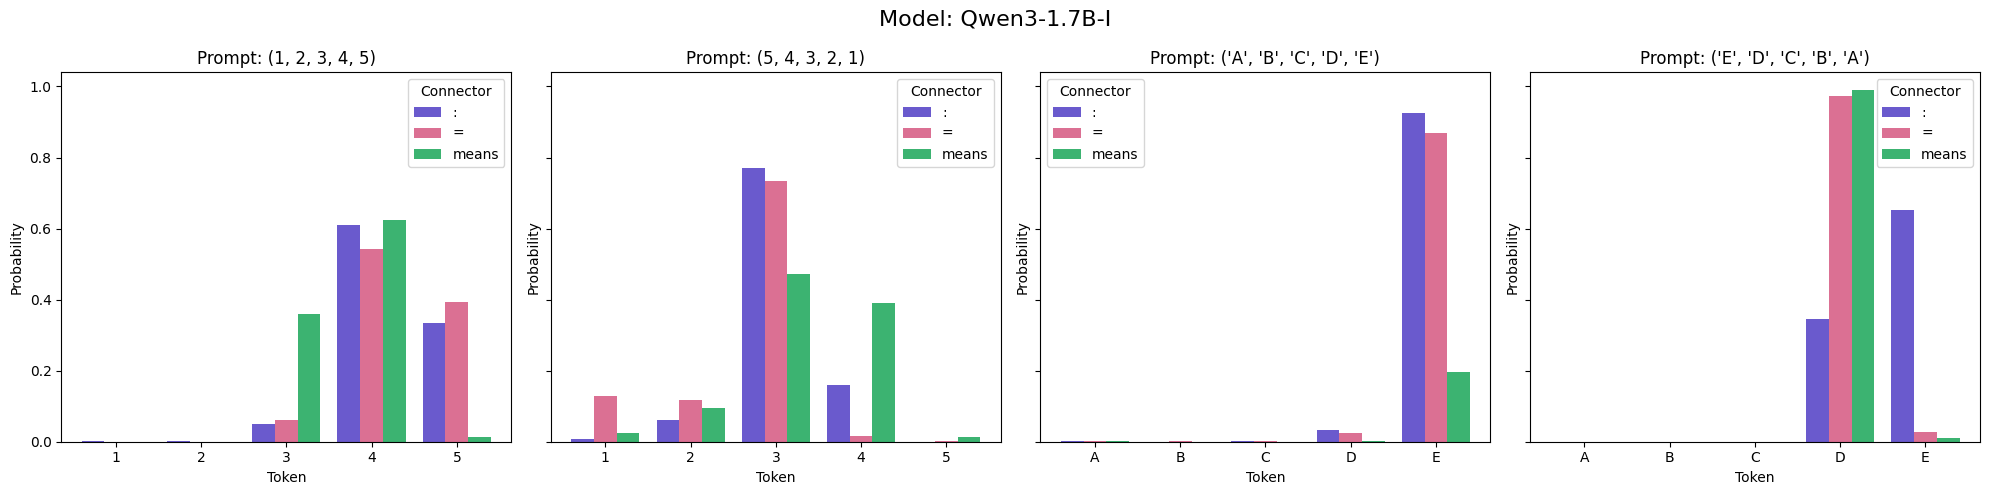

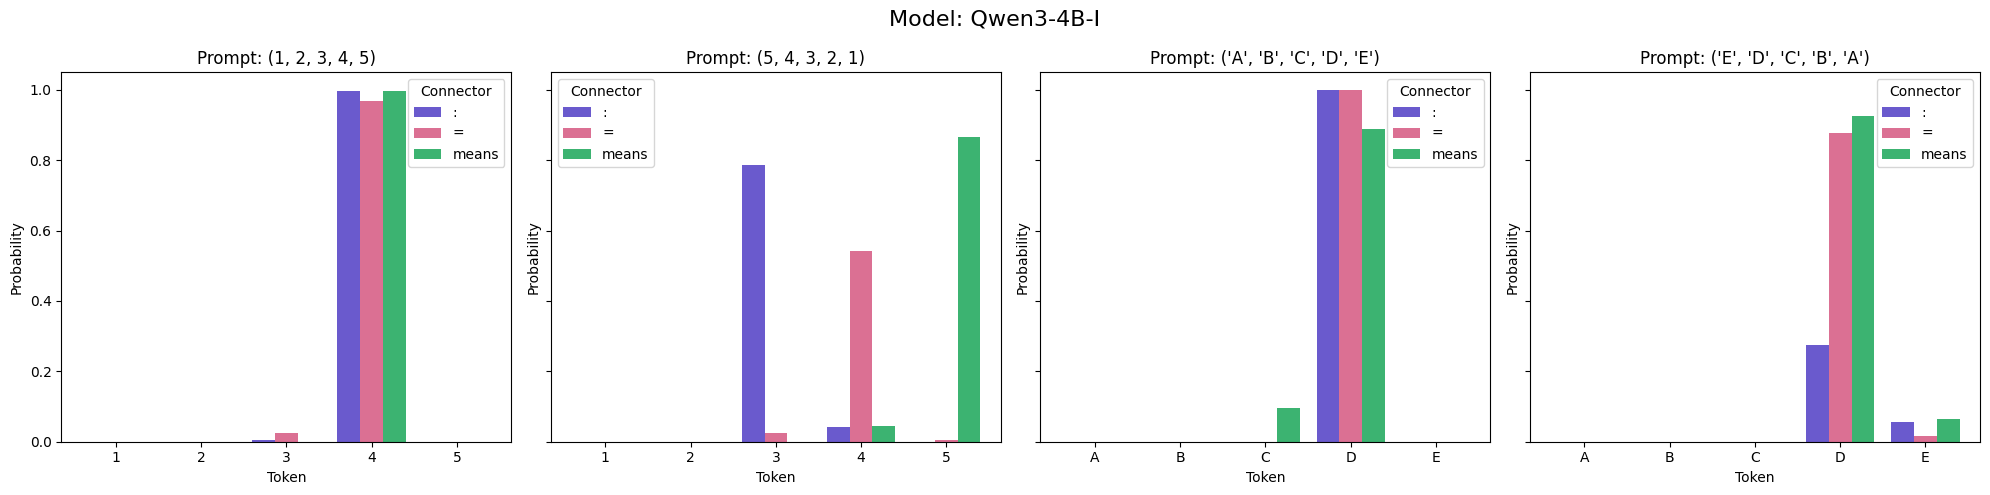

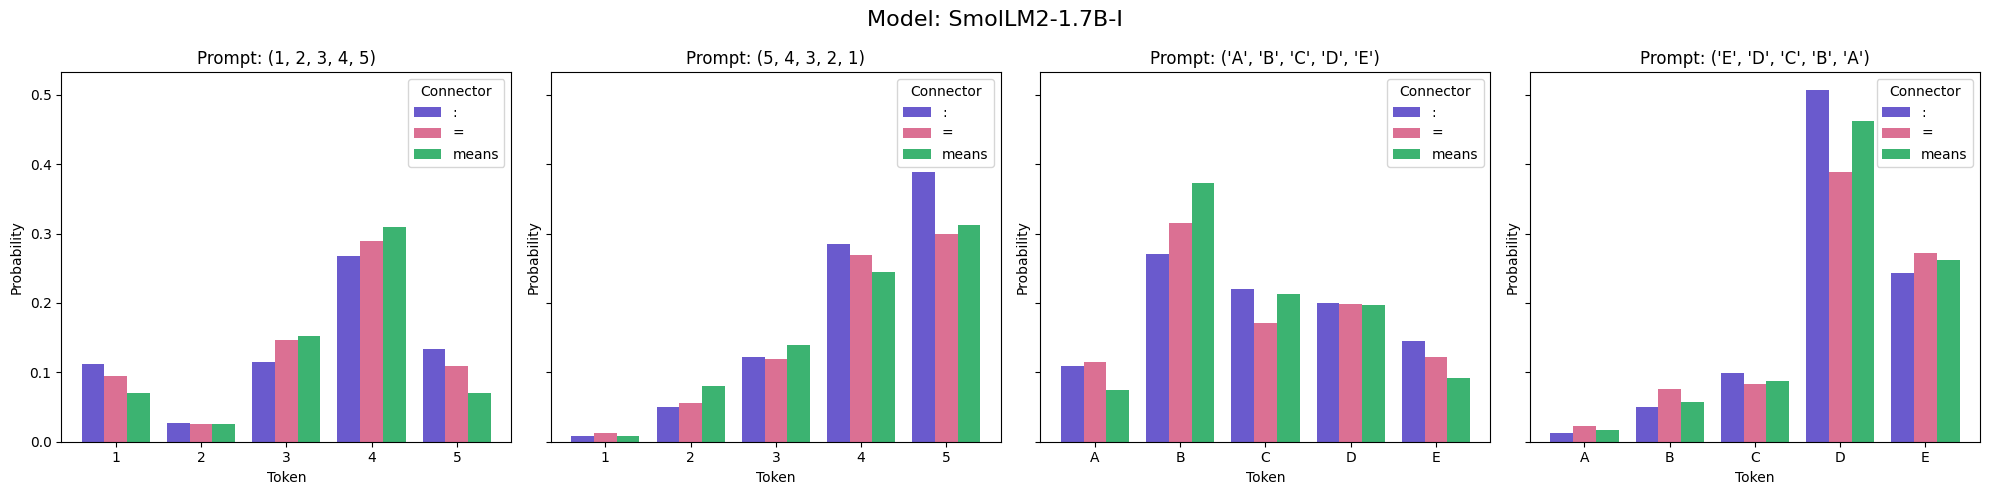

In [11]:
# zurück auf einen Nenner bringen, für verbesserte Vergleichbarkeit. 

# Apply function to normalize scales to dataframe
df[["Token_normalized", "Prob_normalized"]] = df.apply(
    lambda row: pd.Series(normalize_scale(row)), axis=1
)


# Choose a color for each connector type
connector_colors = {
    ":": "slateblue",
    "=": "palevioletred",
    "means": "mediumseagreen"
}

df["prompt_tuple"] = df["prompt_numbers"].apply(lambda x: tuple(x))

# Loop over each model
for model, model_df in df.groupby("model"):

    # Get unique prompt_numbers within this model
    prompts = model_df["prompt_tuple"].unique()
    n_prompts = len(prompts)

    # Create one column per prompt_numbers
    fig, axes = plt.subplots(1, n_prompts, figsize=(5*n_prompts, 5), sharey=True)

    # If only 1 prompt, axes is not a list
    if n_prompts == 1:
        axes = [axes]

    for ax, prompt in zip(axes, prompts):
        subset = model_df[model_df["prompt_tuple"] == prompt]

        # Assume all rows have the same tokens order
        tokens = subset.iloc[0]["Token_normalized"]
        x = np.arange(len(tokens))
        width = 0.8 / len(subset)   # distribute bars within each token group

        # Plot each run (row) as a differently colored bar
        for i, (_, row) in enumerate(subset.iterrows()):
            probs = row["Prob_normalized"]
            connector = row["connector"]
            color = connector_colors.get(connector, "gray")  # default to gray if missing
            ax.bar(x + i*width, probs, width, label=f"{connector}" if connector not in ax.get_legend_handles_labels()[1] else "",
                   color=color)

        ax.set_title(f"Prompt: {prompt}")
        ax.set_xticks(x + width*(len(subset)-1)/2)
        ax.set_xticklabels(tokens)
        ax.set_xlabel("Token")
        ax.set_ylabel("Probability")
        ax.legend(title="Connector")

    fig.suptitle(f"Model: {model}", fontsize=16)
    plt.tight_layout()
    plt.show()
